In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir('../notebook_format')
from formats import load_style
load_style()

In [2]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6 # change default figure size

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload 
%autoreload 2

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib

Ethen 2016-08-03 23:09:40 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1


# Softmax Regression

**Softmax Regression** is a generalization of logistic regression that we can use for multi-class classification. If we want to assign probabilities to an object being one of several different things, softmax is the thing to do. Even later on, when we start training neural network models, the final step will be a layer of softmax.

A softmax regression has two steps: first we add up the evidence of our input being in certain classes, and then we convert that evidence into probabilities.

In **Softmax Regression**, we replace the sigmoid logistic function by the so-called *softmax* function $\phi(\cdot)$.

$$P(y=j \mid z^{(i)}) = \phi(z^{(i)}) = \frac{e^{z^{(i)}}}{\sum_{j=1}^{k} e^{z_{j}^{(i)}}}$$

where we define the net input *z* as 

$$z = w_1x_1 + ... + w_mx_m  + b= \sum_{l=1}^{m} w_l x_l + b= \mathbf{w}^T\mathbf{x} + b$$ 

(**w** is the weight vector, $\mathbf{x}$ is the feature vector of 1 training sample. Each $w$ corresponds to a feature $x$ and there're $m$ of them in total. $b$ is the bias unit. $k$ denotes the total number of classes.)   

Now, this softmax function computes the probability that the $i_{th}$ training sample $\mathbf{x}^{(i)}$ belongs to class $l$ given the weight and net input $z^{(i)}$. So given the obtained weight $w$, we're basically compute the probability, $p(y = j \mid \mathbf{x^{(i)}; w}_j)$, the probability of the training sample belonging to class $j$ for each class label in $j = 1, \ldots, k$. Note the normalization term in the denominator which causes these class probabilities to sum up to one.

We can picture our softmax regression as looking something like the following, although with a lot more $x_s$. For each output, we compute a weighted sum of the $x_s$, add a bias, and then apply softmax.

<img src='images/softmax1.png' width="60%">

If we write that out as equations, we get:

<img src='images/softmax2.png' width="60%">

We can "vectorize" this procedure, turning it into a matrix multiplication and vector addition. This is helpful for computational efficiency. (It's also a useful way to think.)

<img src='images/softmax3.png' width="60%">

To illustrate the concept of softmax, let us walk through a concrete example. Suppose we have a training set consisting of 4 samples from 3 different classes (0, 1, and 2)

- $x_0 \rightarrow \text{class }0$
- $x_1 \rightarrow \text{class }1$
- $x_2 \rightarrow \text{class }2$
- $x_3 \rightarrow \text{class }2$

First, we apply one-hot encoding to encode the class labels into a format that we can more easily work with.

In [3]:
y = np.array([ 0, 1, 2, 2 ])

def one_hot_encode(y):
    class_num = np.unique(y).shape[0]
    y_encode = np.zeros( ( y.shape[0], class_num ) )
    for idx, val in enumerate(y):
        y_encode[ idx, val ] = 1.0
    
    return y_encode

y_encode = one_hot_encode(y)
y_encode

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

A sample that belongs to class 0 (the first row) has a 1 in the first cell, a sample that belongs to class 1 has a 1 in the second cell of its row, and so forth.

Next, let us define the feature matrix of our 4 training samples. Here, we assume that our dataset consists of 2 features; thus, we create a 4x2 dimensional matrix of our samples and features.
Similarly, we create a 2x3 dimensional weight matrix (one row per feature and one column for each class).

In [4]:
X = np.array([[0.1, 0.5],
              [1.1, 2.3],
              [-1.1, -2.3],
              [-1.5, -2.5]])

W = np.array([[0.1, 0.2, 0.3],
              [0.1, 0.2, 0.3]])

bias = np.array([0.01, 0.1, 0.1])

print('Inputs X:\n', X)
print('\nWeights W:\n', W)
print('\nbias:\n', bias)

Inputs X:
 [[ 0.1  0.5]
 [ 1.1  2.3]
 [-1.1 -2.3]
 [-1.5 -2.5]]

Weights W:
 [[ 0.1  0.2  0.3]
 [ 0.1  0.2  0.3]]

bias:
 [ 0.01  0.1   0.1 ]


To compute the net input, we multiply the 4x2 matrix feature matrix `X` with the 2x3 (n_features x n_classes) weight matrix `W`, which yields a 4x3 output matrix (n_samples x n_classes) to which we then add the bias unit: 

$$\mathbf{Z} = \mathbf{X}\mathbf{W} + \mathbf{b}$$

In [5]:
def net_input( X, W, b ):
    return X.dot(W) + b

net_in = net_input( X, W, bias )
print('net input:\n', net_in)

net input:
 [[ 0.07  0.22  0.28]
 [ 0.35  0.78  1.12]
 [-0.33 -0.58 -0.92]
 [-0.39 -0.7  -1.1 ]]


Now, it's time to compute the softmax activation that we discussed earlier:

$$P(y=j \mid z^{(i)}) = \phi_{softmax}(z^{(i)}) = \frac{e^{z^{(i)}}}{\sum_{j=1}^{k} e^{z_{j}^{(i)}}}$$

In [6]:
def softmax(z):
    return np.exp(z) / np.sum( np.exp(z), axis = 1, keepdims = True )

smax = softmax(net_in)
print('softmax:\n', smax)

softmax:
 [[ 0.29450637  0.34216758  0.36332605]
 [ 0.21290077  0.32728332  0.45981591]
 [ 0.42860913  0.33380113  0.23758974]
 [ 0.44941979  0.32962558  0.22095463]]


As we can see, the values for each sample (row) nicely sum up to 1 now. E.g., we can say that the first sample  `[ 0.29450637  0.34216758  0.36332605]` has a 29.45% probability to belong to class 0. Now, in order to turn these probabilities back into class labels, we could simply take the argmax-index position of each row:

[[ 0.29450637  0.34216758  **0.36332605**] -> 2   
[ 0.21290077  0.32728332  **0.45981591**]  -> 2  
[ **0.42860913**  0.33380113  0.23758974]  -> 0  
[ **0.44941979**  0.32962558  0.22095463]] -> 0  

In [7]:
def to_classlabel(z):
    return z.argmax( axis = 1 )

print( 'predicted class labels: ', to_classlabel(smax) )

predicted class labels:  [2 2 0 0]


As we can see, our predictions are terribly wrong, since the correct class labels are `[0, 1, 2, 2]`. Now, in order to train our model we need to measuring how inefficient our predictions are for describing the truth and then optimize on it. To do so we first need to define a loss/cost function $J(\cdot)$ that we want to minimize. One very common function is "cross-entropy":

$$J(\mathbf{W}; \mathbf{b}) = \frac{1}{n} \sum_{i=1}^{n} H( T^{(i)}, O^{(i)} )$$

which is the average of all cross-entropies $H$ over our $n$ training samples. The cross-entropy  function is defined as:

$$H( T^{(i)}, O^{(i)} ) = -\sum_k T^{(i)} \cdot log(O^{(i)})$$

Where:

- $T$ stands for "target" (i.e., the *true* class labels) 
- $O$ stands for output -- the computed *probability* via softmax; **not** the predicted class label.
- $\sum_k$ denotes adding up the difference between the target and the output for all classes.

In [8]:
def cross_entropy_cost( y_target, output ):
    return np.mean( -np.sum( y_target * np.log(output), axis = 1 ) )

cost = cross_entropy_cost( y_target = y_encode, output = smax )
print('Cross Entropy Cost:', cost )

Cross Entropy Cost: 1.32159787159


## Gradient Descent

Our objective in training a neural network is to find a set of weights that gives us the lowest error when we run it against our training data. There're many ways to find these weights and simplest one is so called **gradient descent**. It does this by giving us directions (using derivatives) on how to "shift" our weights to an optimum. It tells us whether we should increase or decrease the value of a specific weight in order to lower the error function.

Let's imagine we have a function $f(x) = x^4 - 3x^3 + 2$ and we want to find the minimum of this function using gradient descent. Here's a graph of that function:

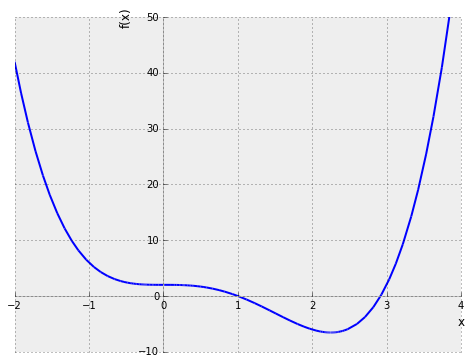

In [9]:
from sympy.plotting import plot
from sympy import symbols, init_printing

# plotting f(x) = x^4 - 3x^3 + 2, showing -2 < x <4
init_printing()
x = symbols('x')
fx = x **4 - 3 * x ** 3 + 2
p1 = plot( fx, ( x, -2, 4 ), ylim = ( -10, 50 ) ) 

As you can see, there appears to be a minimum around ~2.3 or so. Gradient descent answers this question: If we were to start with a random value of x, which direction should we go if we want to get to the lowest point on this function? Let's imagine we pick a random x value, say <b>x = 4</b>, which would be somewhere way up on the right side of the graph. We obviously need to start going to the left if we want to get to the bottom. This is obvious when the function is an easily visualizable 2d plot, but when dealing with functions of multiple variables, we need to rely on the raw mathematics.

Calculus tells us that the derivative of a function at a particular point is the rate of change/slope of the tangent to that part of the function. So let's use derivatives to help us get to the bottom of this function. The derivative of $f(x) = x^4 - 3x^3 + 2$ is $f'(x) = 4x^3 - 9x^2$. So if we plug in our random point from above (x=4) into the first derivative of $f(x)$ we get $f'(4) = 4(4)^3 - 9(4)^2 = 112$. So how does 112 tell us where to go? Well, first of all, it's positive. If we were to compute $f'(-1)$ we get a negative number (-13). So it looks like we can say that whenever the $f'(x)$ for a particular $x$ is positive, we should move to the left (decrease x) and whenever it's negative, we should move to the right (increase x).

We'll now formalize this: When we start with a random x and compute it's deriative $f'(x)$, our <b>new x</b> should then be proportional to $x - f'(x)$. The word proportional is there because we wish to control <em>to what degree</em> we move at each step, for example when we compute $f'(4)=112$, do we really want our new $x$ to be $x - 112 = -108$? No, if we jump all the way to -108, we're even farther from the minimum than we were before. Instead, we want to take relatively <em>small</em> steps toward the minimum. 

Let's say that for any random $x$, we want to take a step (change $x$ a little bit) such that our <b>new $x$</b> $ = x - \alpha*f'(x)$. We'll call $\alpha$ (alpha) our <em>learning rate or step size</em> because it determines how big of a step we take. $\alpha$ is something we will just have to play around with to find a good value. Some functions might require bigger steps, others smaller steps.

Suppose we've set our $\alpha$ to be 0.001. This means, if we randomly started at $f'(4)=112$ then our new $x$ will be $ = 4 - (0.001 * 112) = 3.888$. So we moved to the left a little bit, toward the optimum. Let's do it again. $x_{new} = x - \alpha*f'(3.888) = 3.888 - (0.001 * 99.0436) = 3.79$. Nice, we're indeed moving to the left, closer to the minimum of $f(x)$, little by little. And we'll keep on doing this until we've reached convergence. By convergence, we mean that if the absolute value of the difference between the updated $x$ and the old $x$ is smaller than some randomly small number that we set, denoted as $\epsilon$ (epsilon).

In [10]:
x_old = 0
x_new = 4 # The algorithm starts at x = 4
alpha = 0.01 # step size
epsilon = 0.00001

def f_derivative(x):
    return 4 * x ** 3 - 9 * x ** 2

while abs(x_new - x_old) > epsilon:
    x_old = x_new
    x_new = x_old - alpha * f_derivative(x_old)

print("Local minimum occurs at", x_new)

Local minimum occurs at 2.2500325268933734


The script above says that if the absolute difference of $x$ between the two iterations is not changing by more than 0.00001, then we're probably at the bottom of the "bowl" because our slope is approaching 0, and therefore we should stop and call it a day. Now, if you remember some calculus and algebra, you could have solved for this minimum analytically, and you should get 2.25. Very close to what our gradient descent algorithm above found.

## More Gradient Descent...

As you might imagine, when we use gradient descent for a neural network, things get a lot more complicated. Not because gradient descent gets more complicated, it still ends up just being a matter of taking small steps downhill, it's that we need that pesky derivative in order to use gradient descent, and the derivative of a neural network cost function (with respect to its weights) is pretty intense. It's not a matter of just analytically solving $f(x)=x^2, f'(x)=2x$ , because the output of a neural net has many nested or "inner" functions.

Also unlike our toy math problem above, a neural network may have many weights. We need to find the optimal value for each individual weight to lower the cost for our entire neural net output. This requires taking the partial derivative of the cost/error function with respect to a single weight, and then running gradient descent for each individual weight. Thus, for any individual weight $W_j$, we'll compute the following:

$$ W_j^{(t + 1)} = W_j^{(t)} - \alpha * \frac{\partial L}{\partial W_j}$$ 

Where:

- $L$ denotes the loss function that we've defined.
- $W_j^{(t)}$ denotes the weight of the $j_{th}$ feature at iteration $t$.

And as before, we do this iteratively for each weight, many times, until the whole network's cost function is minimized.

In order to learn the weight for our softmax model via gradient descent, we then need to compute the gradient of our cost function for each class $j \in \{0, 1, ..., k\}$.

$$\nabla \mathbf{w}_j \, J(\mathbf{W}; \mathbf{b})$$

We won't be going through the tedious details here, but this cost's gradient turns out to be simply:

$$\nabla \mathbf{w}_j \, J(\mathbf{W}; \mathbf{b}) = \frac{1}{n} \sum^{n}_{i=0} \big[\mathbf{x}^{(i)}_j\ \big( O^{(i)} - T^{(i)} \big) \big]$$

We can then use the cost derivate to update the weights in opposite direction of the cost gradient with learning rate $\eta$:

$$\mathbf{w}_j := \mathbf{w}_j - \eta \nabla \mathbf{w}_j \, J(\mathbf{W}; \mathbf{b})$$ 

(note that $\mathbf{w}_j$ is the weight vector for the class $y=j$), and we update the bias units using:

$$
\mathbf{b}_j := \mathbf{b}_j   - \eta \bigg[ \frac{1}{n} \sum^{n}_{i=0} \big( O^{(i)} - T^{(i)} \big) \bigg]
$$ 
 

As a penalty against complexity, an approach to reduce the variance of our model and decrease the degree of overfitting by adding additional bias, we can further add a regularization term such as the L2 term with the regularization parameter $\lambda$:
    
$$\frac{\lambda}{2} ||\mathbf{w}||_{2}^{2}$$

where $||\mathbf{w}||_{2}^{2}$ simply means adding up the squared weights across all the features and classes.

$$||\mathbf{w}||_{2}^{2} = \sum^{m}_{l=0} \sum^{k}_{j=0} w_{l, j}^2$$

so that our cost function becomes

$$
J(\mathbf{W}; \mathbf{b}) = \frac{1}{n} \sum_{i=1}^{n} H( T^{(i)}, O^{(i)} ) + \frac{\lambda}{2} ||\mathbf{w}||_{2}^{2}
$$

and we define the "regularized" weight update as

$$
\mathbf{w}_j := \mathbf{w}_j -  \eta \big[\nabla \mathbf{w}_j \, J(\mathbf{W}) + \lambda \mathbf{w}_j \big]
$$

Note that we don't regularize the bias term, thus the update function for it stays the same.

## Softmax Regression Code

Bringing the concepts together, we could come up with an implementation as follows: Note that for the weight and bias parameter, we'll have initialize a value for it. Here we'll simply draw the weights from a normal distribution and set the bias as zero. The code can be obtained [here](https://github.com/ethen8181/machine-learning/blob/master/deep_learning/softmax.py).

In [11]:
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# manually standardize the feautures
for i in range(X.shape[1]):
    X[ :, i ] = ( X[ :, i ] - X[ :, i ].mean() ) / X[ :, i ].std()

In [12]:
from softmax import SoftmaxRegression

# train the softmax using batch gradient descent
softmax_reg = SoftmaxRegression( eta = 0.05, epochs = 10, minibatches = y.shape[0] )
softmax_reg.fit( X, y )

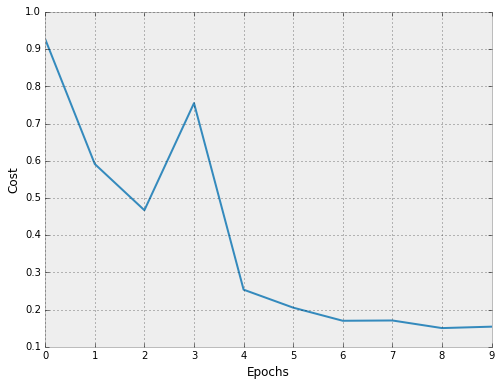

In [13]:
plt.plot( range( len(softmax_reg.costs) ), softmax_reg.costs )
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

In [16]:
y_pred = softmax_reg.predict(X)
accuracy = np.sum( y_pred == y ) / y.shape[0]
print(accuracy)

0.946666666667


In [17]:
# comparet the results
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit( X, y )
y_pred = log_reg.predict(X)
print( accuracy_score( y_true = y, y_pred = y_pred ) )

0.926666666667


## Reference

- [TensorFlow - Softmax Regression](https://www.tensorflow.org/versions/r0.9/tutorials/mnist/beginners/index.html)
- [Sebastian Raschka - Softmax Regression](http://nbviewer.jupyter.org/github/rasbt/python-machine-learning-book/blob/master/code/bonus/softmax-regression.ipynb)
- [Gradient Descent Example with Backpropagation](http://outlace.com/Beginner-Tutorial-Backpropagation/)